# Training of Model

## Imports

In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

## Preprocessing and Data Preperation

In [3]:
# grab the list of images in our dataset directory, then initialize
# the list of images and their class images
imagePaths = list(paths.list_images('Blood_noblood/'))
data = []
labels = []

# loop over each image in the image paths
for imagePath in imagePaths:
    
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]
    
    # load the input image and preprocess the image
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
    
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
    
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [4]:
#data.shape, labels.shape

## Prepare the Model Architecture -Train, Complile and Predictions 

In [5]:
# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-4
EPOCHS = 30
BS = 32

# load the MobileNetV2 network, leaving the head FC layer sets
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they wil 
# dont get updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])

# train the head of the network
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)

# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

Epoch 1/30
10/10 [==============================] - 11s 850ms/step - loss: 0.8505 - accuracy: 0.5351 - val_loss: 0.6988 - val_accuracy: 0.5625
Epoch 2/30
10/10 [==============================] - 8s 742ms/step - loss: 0.7920 - accuracy: 0.5509 - val_loss: 0.6412 - val_accuracy: 0.6375
Epoch 3/30
10/10 [==============================] - 8s 745ms/step - loss: 0.7106 - accuracy: 0.5532 - val_loss: 0.5919 - val_accuracy: 0.7125
Epoch 4/30
10/10 [==============================] - 8s 760ms/step - loss: 0.6372 - accuracy: 0.6436 - val_loss: 0.5528 - val_accuracy: 0.7625
Epoch 5/30
10/10 [==============================] - 8s 781ms/step - loss: 0.5415 - accuracy: 0.7526 - val_loss: 0.5203 - val_accuracy: 0.8375
Epoch 6/30
10/10 [==============================] - 8s 797ms/step - loss: 0.5322 - accuracy: 0.7673 - val_loss: 0.4923 - val_accuracy: 0.8250
Epoch 7/30
10/10 [==============================] - 9s 849ms/step - loss: 0.5282 - accuracy: 0.7844 - val_loss: 0.4691 - val_accuracy: 0.8750
Epoch

###  Serialize model to disk 

In [6]:
# serialize the model to disk
model.save('blood_noblood_classifier.model', save_format="h5")

### Evaluate the model performance

In [7]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=lb.classes_))

# show a nicely formatted classification report
print(confusion_matrix(testY.argmax(axis=1), predIdxs))

# show a nicely formatted classification report
print(accuracy_score(testY.argmax(axis=1), predIdxs))

              precision    recall  f1-score   support

       Blood       0.90      0.93      0.91        40
    No_Blood       0.92      0.90      0.91        40

    accuracy                           0.91        80
   macro avg       0.91      0.91      0.91        80
weighted avg       0.91      0.91      0.91        80

[[37  3]
 [ 4 36]]
0.9125


### Plot the training and accuracy Plot

KeyError: 'acc'

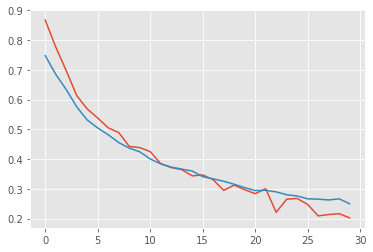

In [9]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig('model_plot.png')

# Make Predictions in Images

In [ ]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import os


# load our serialized face detector model from disk
prototxtPath = os.path.sep.join(['Model', "deploy.prototxt"])
weightsPath = os.path.sep.join(['Model', "res10_300x300_ssd_iter_140000.caffemodel"])
net = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the blood face detector model from disk
model = load_model('blood_noblood_classifier.model')





# load the input image from disk, clone it, and grab the image spatial
# dimensions
image = cv2.imread('a.jpg')
orig = image.copy()
(h, w) = image.shape[:2]

# construct a blob from the image
blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

# pass the blob through the network and obtain the face detections
net.setInput(blob)
detections = net.forward()

# loop over the detections
for i in range(0, detections.shape[2]):
    
    # extract the confidence (i.e., probability) associated with
    # the detection
    confidence = detections[0, 0, i, 2]
    
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    
    if confidence > 0.6:
        
        # compute the (x, y)-coordinates of the bounding box for
        # the object
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        
        # ensure the bounding boxes fall within the dimensions of
        # the frame
        (startX, startY) = (max(0, startX), max(0, startY))
        (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
        face = image[startY:endY, startX:endX]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        face = cv2.resize(face, (224, 224))
        face = img_to_array(face)
        face = preprocess_input(face)
        face = np.expand_dims(face, axis=0)
        
        print(type(face))
        # pass the face through the model to determine if the face
        # has a mask or not
        (blood, noblood) = model.predict(face)[0]


        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Blood" if blood > noblood else "No Blood"
        color = (0, 0, 255) if label == "Blood" else (0, 255, 0)
        
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(blood, noblood) * 100)
        
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(image, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)
        
# show the output image
cv2.imshow("Output", image)
cv2.waitKey(0)

<class 'numpy.ndarray'>


# Make Predictions in Real Time in Video

In [1]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os

# define a helper function to detected face and bounding box for each image 
# in a live video frame
def detect_and_predict_blood(frame, bloodNet, check):
    
    # grab the dimensions of the frame and then construct a blob
    # from it
    # (h, w) = frame.shape[:2]
    # blob = cv2.dnn.blobFromImage(frame, 1.0, (300, 300), (104.0, 177.0, 123.0))
    
    # pass the blob through the network and obtain the face detections
    # faceNet.setInput(blob)
    # detections = faceNet.forward() # DV: This should output where it thinks all the faces are
    # detections = frame
    if check == True:
        print("Detections after faceNet")
        #print(type(detections))
        #print(detections)
    # initialize our list of faces, their corresponding locations,
    # and the list of predictions from our face mask network
    faces = []
    locs = [1]
    preds = []

# loop over the detections
    #for i in range(0, detections.shape[2]): # DV: since we are not detecting, comment this out
        
        # extract the confidence (i.e., probability) associated with
        # the detection
        # confidence = detections[0, 0, i, 2]
        
        # filter out weak detections by ensuring the confidence is
        # greater than the minimum confidence
        # if confidence > 0.5:
            #DV Since we are not doing confidence on whether it is actually a face
        # compute the (x, y)-coordinates of the bounding box for
        # the object, DV: Which is the face. These two code draw the picture around the box
        #box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        #(startX, startY, endX, endY) = box.astype("int")

        # ensure the bounding boxes fall within the dimensions of
        # the frame
        #(startX, startY) = (max(0, startX), max(0, startY))
        #(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

        # extract the face ROI, convert it from BGR to RGB channel
        # ordering, resize it to 224x224, and preprocess it
    #face = frame#[startY:endY, startX:endX] # DV: Take the entire frame instead, so we are commenting this out
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (224, 224))
    frame = img_to_array(frame)
    frame = preprocess_input(frame)

        # add the face and bounding boxes to their respective
        # lists
    faces.append(frame)
        #locs.append((startX, startY, endX, endY))

        # only make a predictions if at least one face was detected
    # if len(faces) > 0: # DV: If there are faces detected. In this case, we want to run this anyways on the entire frame
        
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
    if check == True:
        print("Faces before turning into np.array:")
        #print(type(faces))
        #print(faces)
    faces = np.array(faces, dtype="float32")
    preds = bloodNet.predict(faces, batch_size=32) # DV: bloodNet should be our model to detect blood in a frame
    if check == True:
        print("Printing preds:")
        print(type(preds))
        print(preds)
    # return a 2-tuple of the face locations and their corresponding
    # locations
    return (locs, preds)

# load our serialized face detector model from disk. DV: since we are not detecting faces, comment this out
#prototxtPath = os.path.sep.join(['Model', "deploy.prototxt"])
#weightsPath = os.path.sep.join(['Model', "res10_300x300_ssd_iter_140000.caffemodel"])
#faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
bloodNet = load_model(r'C:\Users\Dylan Vu\Visual Studio Code Projects\Projects\red-alert\blood_noblood_classifier.model') # DV: Change the path to our model

# initialize the video stream and allow the camera sensor to warm up
vs = VideoStream(src=0).start()
time.sleep(2.0)

# loop over the frames from the video stream
while True:
    
    # grab the frame from the threaded video stream and resize it
    # to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)
    
    # detect faces in the frame and determine if they are wearing a
    # face mask or not
    (locs, preds) = detect_and_predict_blood(frame, bloodNet, False)

    # loop over the detected face locations and their corresponding
    # locations
    # DV: Idea: remove box, just loop through preds
    for (box, pred) in zip(locs, preds): # DV: This may be for multiple faces? Potentially remove for a single face
        
        # unpack the bounding box and predictions
        #(startX, startY, endX, endY) = box
        (blood, noblood) = pred
        
        # determine the class label and color we'll use to draw
        # the bounding box and text
        label = "Blood" if blood > noblood else "No Blood"
        color = (0, 0, 255) if label == "Blood" else (0, 255, 0)
        
        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(blood, noblood) * 100)
        
        # display the label and bounding box rectangle on the output
        # frame
        cv2.putText(frame, label, (20, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        #cv2.rectangle(frame, (10, 10), (endX, endY), color, 2)

    # show the output frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF
    
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        # DV: Check the last frame
        print("Q was pressed")
        (locs, preds) = detect_and_predict_blood(frame, bloodNet, True)
        print("Detect and predict ran")
        print((locs, preds))
        for (box, pred) in zip(locs, preds):
            print("Iteration started")
            (blood, noblood) = pred
            print("The blood no blood tuple")
            print((blood, noblood))
            if blood > noblood:
                print("Blood detected")
            else:
                print("No blood detected")
        break
        
# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

Q was pressed
Detections after faceNet
Faces before turning into np.array:
Printing preds:
<class 'numpy.ndarray'>
[[0.00455763 0.9954424 ]]
Detect and predict ran
([1], array([[0.00455763, 0.9954424 ]], dtype=float32))
Iteration started
The blood no blood tuple
(0.0045576277, 0.9954424)
No blood detected


In [11]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
import os


# load our serialized face detector model from disk
prototxtPath = os.path.sep.join(['Model', "deploy.prototxt"])
weightsPath = os.path.sep.join(['Model', "res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
bloodNet = load_model('blood_noblood_classifier.model')

image = 'a.jpg'
image = cv2.imread(image)

face = image
face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
face = cv2.resize(face, (224, 224))
face = img_to_array(face)
face = preprocess_input(face)
face = np.expand_dims(face, axis=0)

prediction = bloodNet.predict(face)
print(prediction) 

[[0.9778896  0.02211036]]
